In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

from datetime import datetime
import tclab
import time
import os
from IPython.display import display, clear_output

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import PID_RT,Lead_Lag_RT,IMC_tuning

In [20]:
# # Wrong DV respone
# #SOPDT PV
# Kp = 0.6738137025155853
# T1p = 183.44770757727215
# T2p = 5.327855225788805e-05
# thetap = 10.192078303908199

# #SOPDT DV
# Kd = 0.36816132905697
# T1d = 128.19758463380253
# T2d = 26.094509776696448
# thetad = 2.000174864808916

In [21]:
#SOPDT PV in-out dynamics params
Kp = 0.6738137025155853
T1p = 183.44770757727215
T2p = 10.192078303908199
thetap = 10.192078303908199

#SOPDT DV disturbance dynamics params
Kd = 0.45188195989398117
T1d = 93.79714286404828
T2d = 47.79759461272312
thetad = 2.0000001555147313

In [22]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 75
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
MVPath = {0:1, 100:0, TSim:1}
#MVPath = {0:1, 100:0, TSim:1}

gamma = 0.6 
Kc,Ti,Td = IMC_tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print(Kc,Ti,Td)
alpha = 0.5
MVMin = 0
MVMax = 100

2.2638562103704953 183.4477608558244 5.327853678425066e-05


In [23]:
title = "OLP_NO_FF"
ManPath = {0: True, TSim: True}                # Path for Man
MVManPath = {0: MV0 , TSim : MV0}              #path for MVMan
SPPath = {0: PV0, TSim: MV0}                   # Path for SP, always the same in most cases
DVPath = {0: 50.0, 1000: 60, TSim: 60.0}       # Path for DV
ActivateFF = False
ManFF = True

# title = "OLP_FF"         
# ManPath = {0: True, TSim: True}               # Path for Man
# MVManPath = {0: MV0, TSim: MV0}               # Path for MVMan
# SPPath = {0: PV0, TSim: PV0}                  # Path for SP, always the same in most cases
# DVPath = {0: 50.0, 1000: 60,  TSim: 60.0}     # Path for DV
# ActivateFF = True
# ManFF = True

# title = "CLP_NO_FF"  
# ManPath = {0:True, 500: False, TSim: False}   # Path for Man
# MVManPath = {0: MV0+10, TSim: MV0+10}         # Path for MVMan
# SPPath = {0: PV0+5, 1200:PV0-5, TSim: PV0-5}  # Path for SP, always the same in most cases
# DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10} # Path for DV
# ActivateFF = False
# ManFF= False

# title = "CLP_FF"                                # test done
# ManPath = {0: True, 500: False,  TSim: False}   # Path for Man
# MVManPath = {0: MV0+10, TSim: MV0+10}           # Path for MVMan
# SPPath = {0: PV0+5,1200:PV0-5, TSim: PV0-5}     # Path for SP, always the same in most cases
# DVPath = {0: DV0,2000: DV0+10, TSim: DV0+10}    # Path for DV
# ActivateFF = True
# ManFF= False

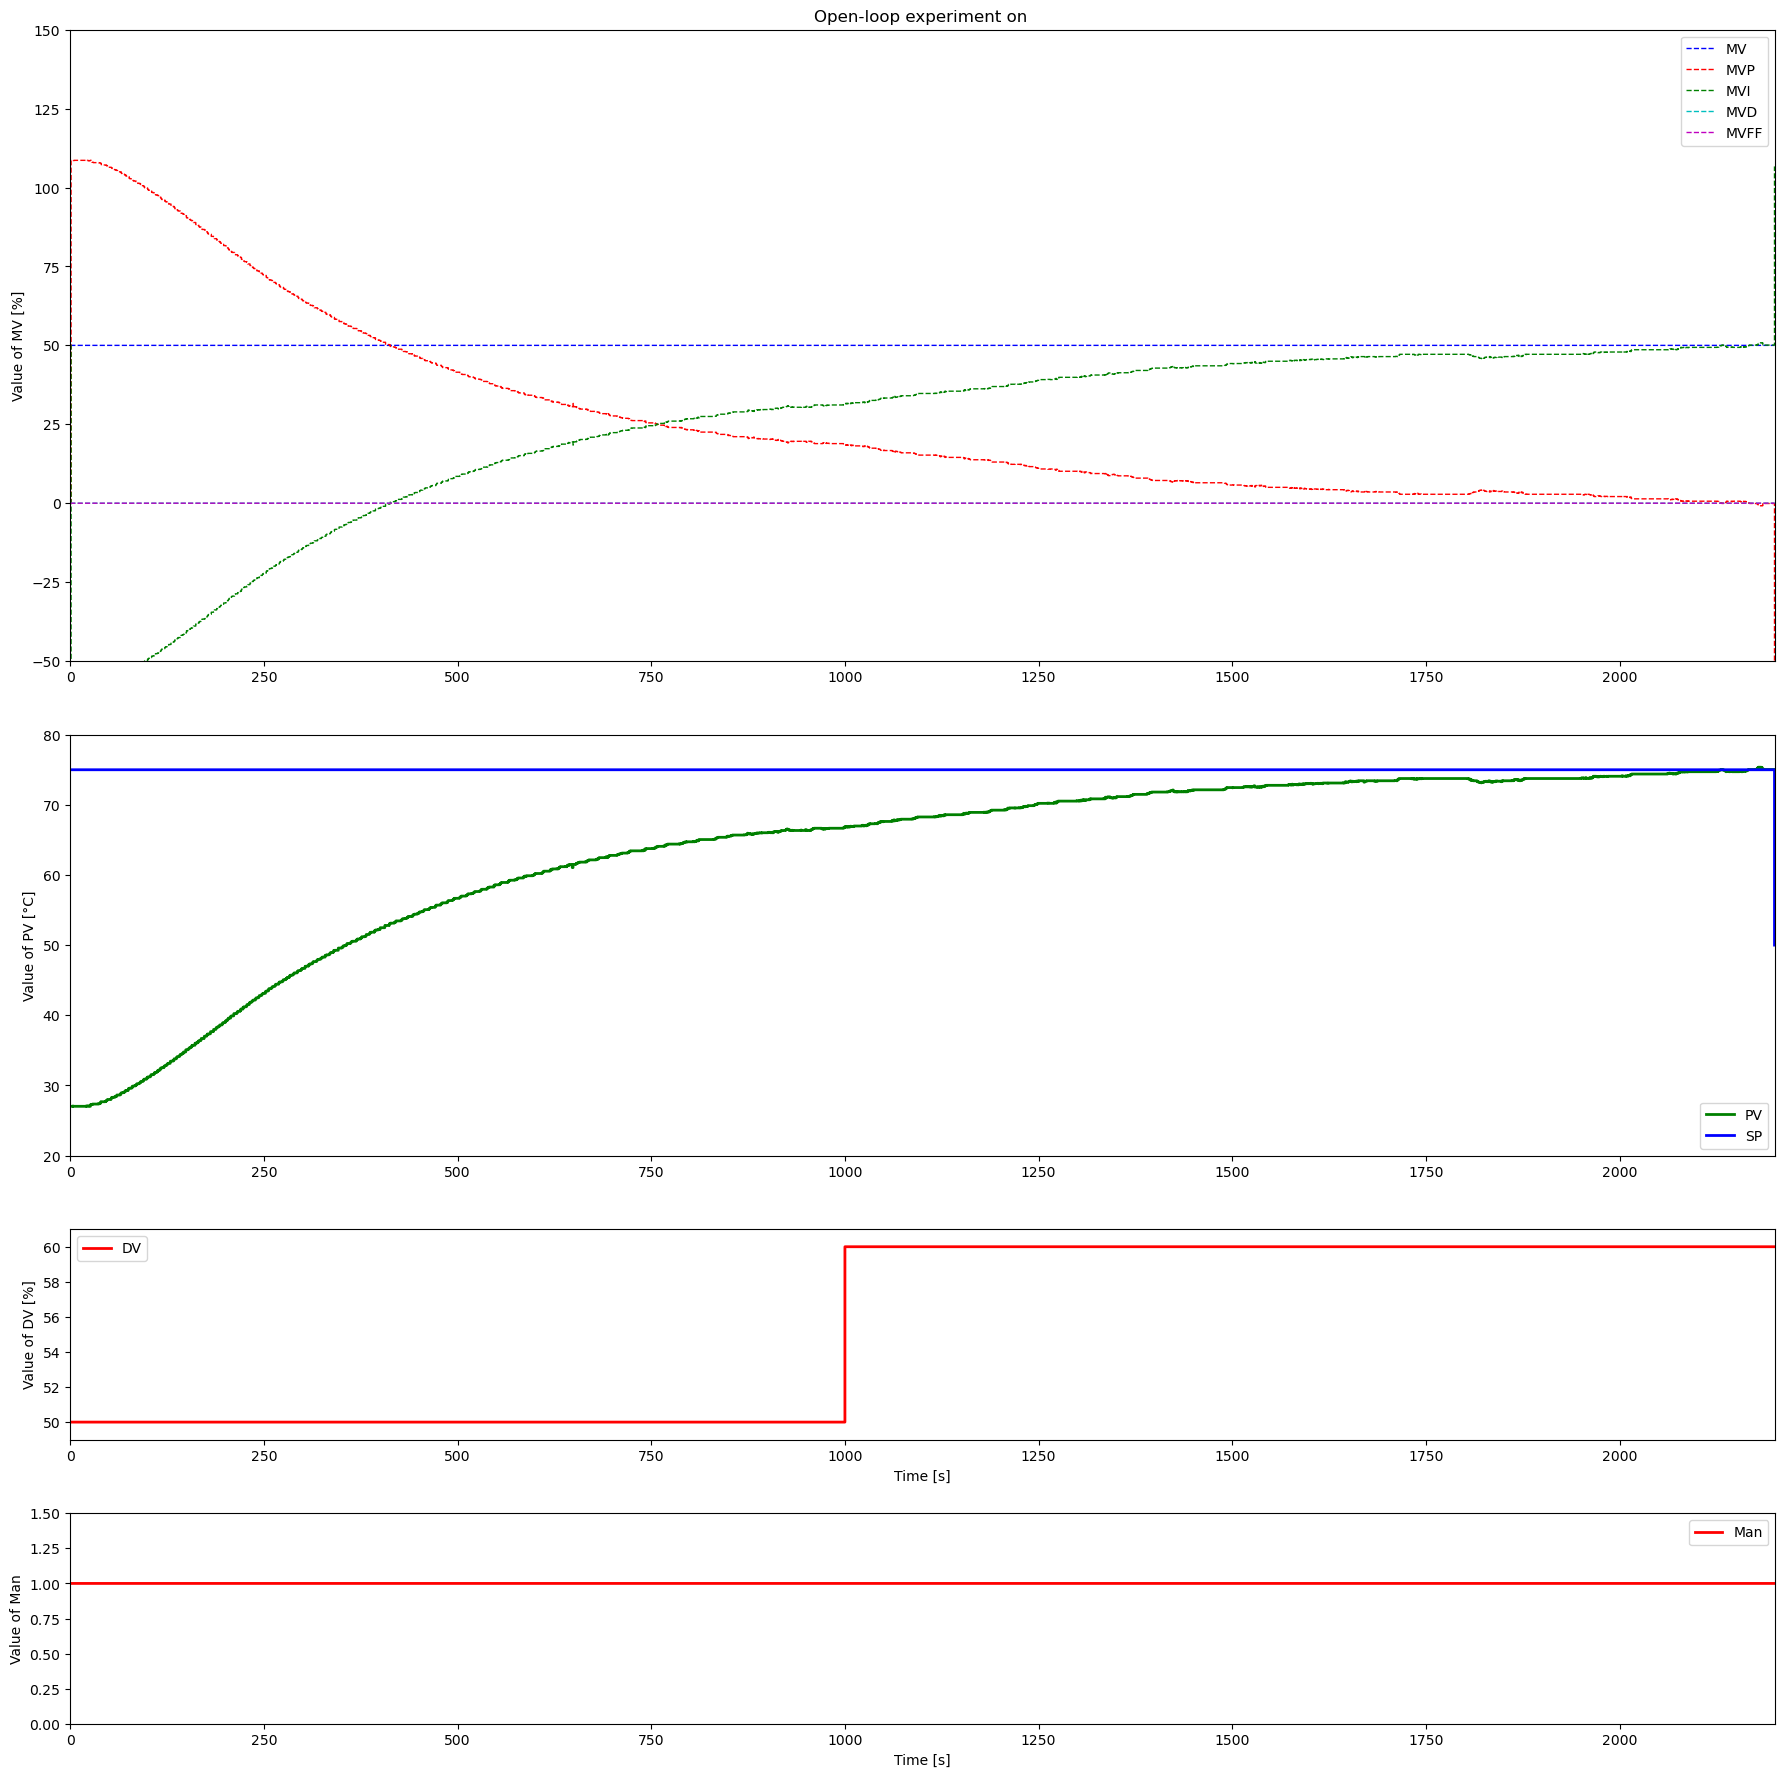

TCLab disconnected successfully.


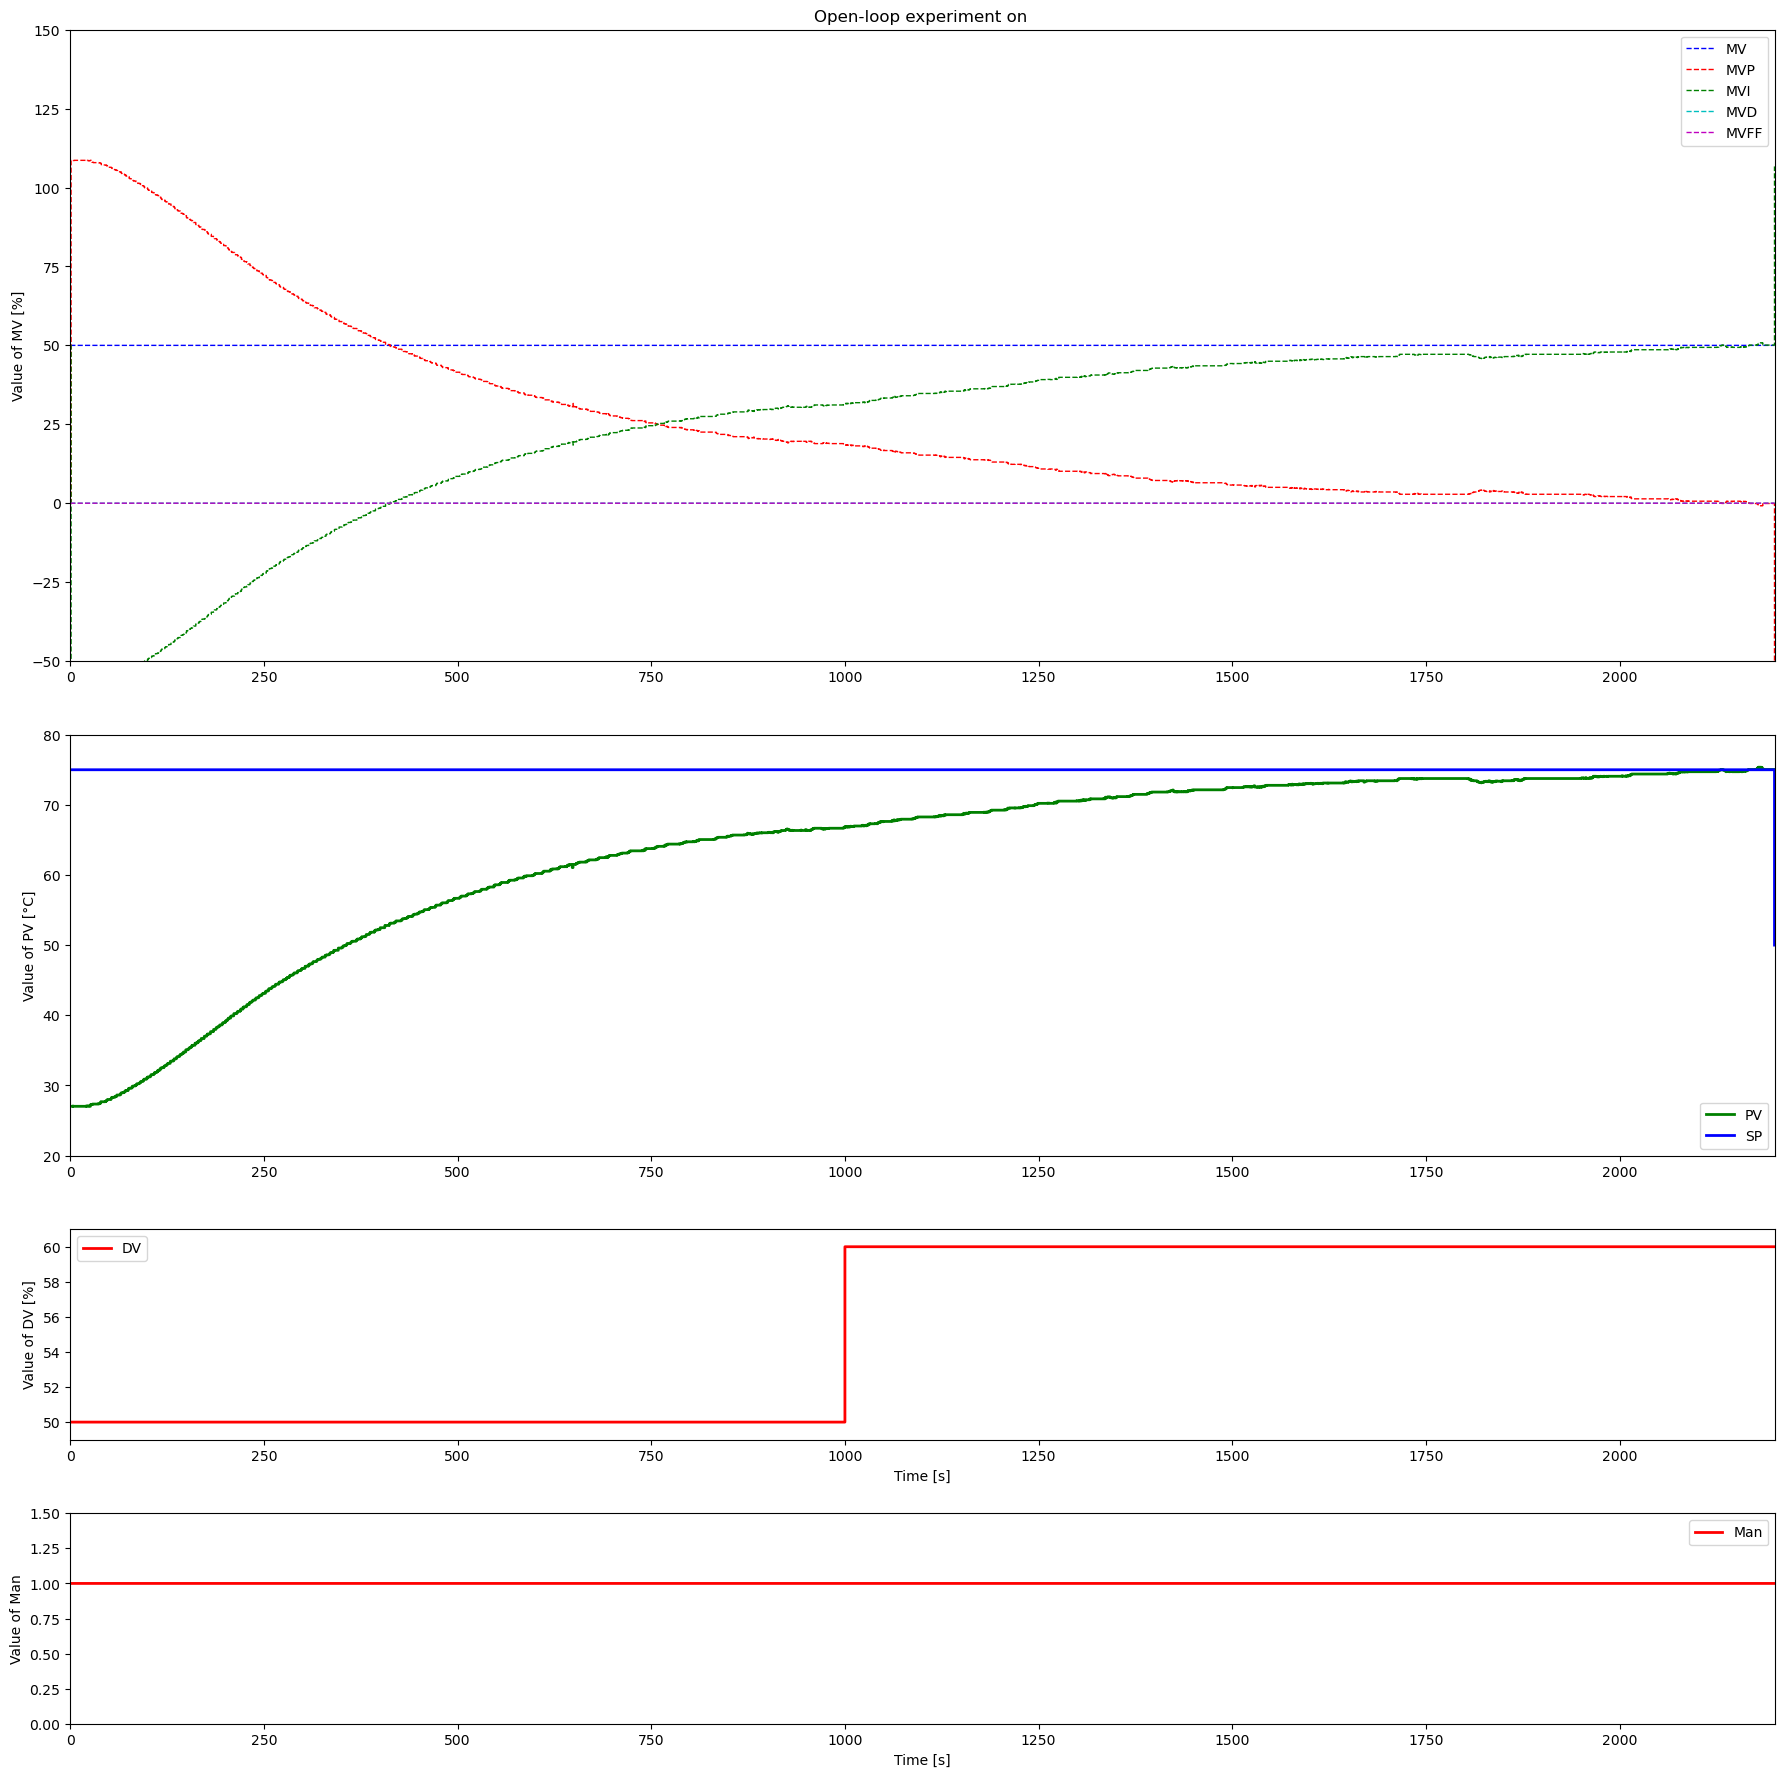

In [24]:
t = []
MVP=[]
MVI=[]
MVD=[]
DV = []
PV = []
SP = []
MV = []
E = []
MVFF = []
MVMan=[]
Man = []
MVFFDelay = []
MVFFLL = []
MVDelayp = []
MVDelayd = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []

lab = tclab.TCLab()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, gridspec_kw={'height_ratios': [3, 2, 1, 1]})
fig.set_figheight(22)
fig.set_figwidth(22)

l10, = ax1.step([0,1],[0,100],'b--',linewidth=1,label='MV',where='post')
l11, = ax1.step([0,1],[0,100],'r--',linewidth=1,label='MVP',where='post')
l12, = ax1.step([0,1],[0,100],'g--',linewidth=1,label='MVI',where='post')
l13, = ax1.step([0,1],[0,100],'c--',linewidth=1,label='MVD',where='post')
l14, = ax1.step([0,1],[0,100],'m--',linewidth=1,label='MVFF',where='post')

ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Open-loop experiment on ')
ax1.legend(loc='best')

l20, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
l21, = ax2.step([0,1],[0,100],'b-',linewidth=2,label='SP',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l30, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

l40, = ax4.step([0,1],[0,100],'r-',linewidth=2,label='Man',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of Man')
ax4.legend(loc='best')

for i in range(0,N):
    t.append(i*Ts)
    
    #SP DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    #FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    Lead_Lag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL)
    Lead_Lag_RT(MVFFLL,int(ActivateFF),T2p,T2d,Ts,MVFF)
    
    #
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    #PID
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    #TCLab
    lab.Q1(MV[-1])
    lab.Q2(DV[-1])
    
    #Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(lab.T1)
    
    l10.set_data(t,MV)
    l11.set_data(t,MVP)
    l12.set_data(t,MVI)
    l13.set_data(t,MVD)
    l14.set_data(t,MVFF)
    
    l20.set_data(t,PV)
    l21.set_data(t,SP)
    
    l30.set_data(t,DV)
    
    l40.set_data(t,Man)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    
    if i > 1:
        # ax1.set_ylim(myRound(np.min(MVFF),5)-5, myRound(np.max(MV),5)+5)
        ax1.set_ylim(-50, 150)
        ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(SP),5)+5)
        ax3.set_ylim(myRound(np.min(DV),5)-1, myRound(np.max(DV),5)+1)  
        ax4.set_ylim(myRound(np.min(Man),5), myRound(np.max(Man),5)+1.5)        
    
    display(fig) 
lab.close()

#save TXT file
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
t = np.array(t)
MV = np.array(MV)
PV = np.array(PV)
DV = np.array(DV)
SP = np.array(SP)
MVFF = np.array(MVFF)
Man = np.array(Man)
MVP= np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
my_data = np.vstack((t.T,MV.T,MVP.T, MVI.T, MVD.T, SP.T, DV.T, Man.T, MVFF.T))
my_data = my_data.T
nameFile = 'REPORT/TCLAB_experiment_with_' + title + '_' + date_time + '.txt'
if not os.path.exists('REPORT'):
    os.makedirs('REPORT')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,SP,PV,DV,Man,MVFF',comments='')

#save PLOT
plt.savefig(nameFile + '.png',transparent=True)
